In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
import sklearn.metrics as skm
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from evaluate_function import evaluate_model


In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0


In [4]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [5]:
y.mean()

0.01804147465437788

In [32]:
y.value_counts()

stroke
0    42617
1      783
Name: count, dtype: int64

## Processing Pipeline

Here is an example of a complex pipeline, with different processors for numeric and categorical as well as transformers for "pass through" columns (do nothing) and "drop" columns. 

In [5]:
class DropFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        self.fitted_ = True
        return self  

    def transform(self, X):
        # Ensure X is a DataFrame (necessary to drop by column names)
        if isinstance(X, pd.DataFrame):
            return X.drop(columns=self.features_to_drop, errors='ignore')
        else:
            raise ValueError("Input must be a pandas DataFrame")
        
        
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass  # No parameters needed

    def fit(self, X, y=None):
        self.fitted_ = True
        return self  

    def transform(self, X):
        return X  # Returns the input unchanged


In [6]:
non_numeric_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numeric_columns = ['age','avg_glucose_level', 'bmi']
passthru_columns = ['hypertension', 'heart_disease']
drop_columns = ['id']


numeric_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

category_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

nothing_pipeline = Pipeline([
    ('nothing', IdentityTransformer())
])

combiner = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('category', category_pipeline, non_numeric_columns),
    ('passthru', nothing_pipeline, passthru_columns)
])

preprocessor = Pipeline([
    ('drop', DropFeatureTransformer(drop_columns)),
    ('preprocessor', combiner)
])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=142)

In [8]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [9]:
## Convert to dataframe if desired
# X_train_df = pd.DataFrame(X_train_preprocessed, columns=numeric_columns + list(preprocessor.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(non_numeric_columns)) + passthru_columns) 
# X_test_df = pd.DataFrame(X_test_preprocessed, columns=numeric_columns + list(preprocessor.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(non_numeric_columns)) + passthru_columns)   

## Fit Baseline Model

In [10]:
model_base = LogisticRegressionCV(max_iter=1000)
model_base.fit(X_train_preprocessed, y_train)
model_base.C_



array([0.0001])

Test Accuracy: 0.9819
Confusion Matrix:
[[8523    0]
 [ 157    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8523
           1       0.00      0.00      0.00       157

    accuracy                           0.98      8680
   macro avg       0.49      0.50      0.50      8680
weighted avg       0.96      0.98      0.97      8680

ROC AUC: 0.8263
PR AUC: 0.0662


/Users/sneeley/miniconda3/envs/shared/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sneeley/miniconda3/envs/shared/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sneeley/miniconda3/envs/shared/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

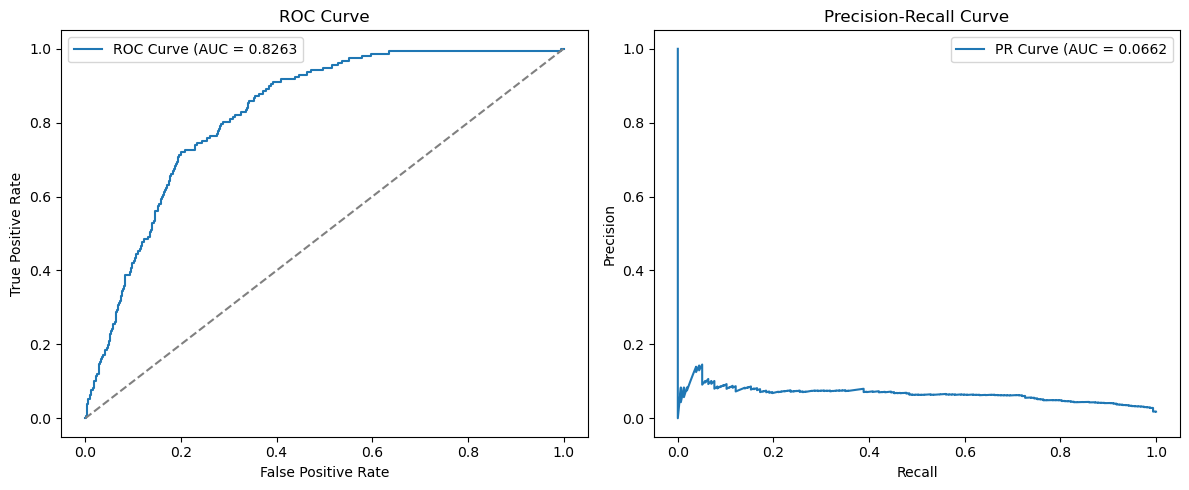

In [11]:
evaluate_model(model_base, X_test_preprocessed, y_test)

## SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
smote = SMOTE(random_state=35)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)

In [14]:
model_smote = LogisticRegressionCV(max_iter=1000)
model_smote.fit(X_train_resampled, y_train_resampled)
model_smote.C_



array([2.7825594])

Test Accuracy: 0.7361
Confusion Matrix:
[[6271 2252]
 [  39  118]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      8523
           1       0.05      0.75      0.09       157

    accuracy                           0.74      8680
   macro avg       0.52      0.74      0.47      8680
weighted avg       0.98      0.74      0.83      8680

ROC AUC: 0.8253
PR AUC: 0.0717


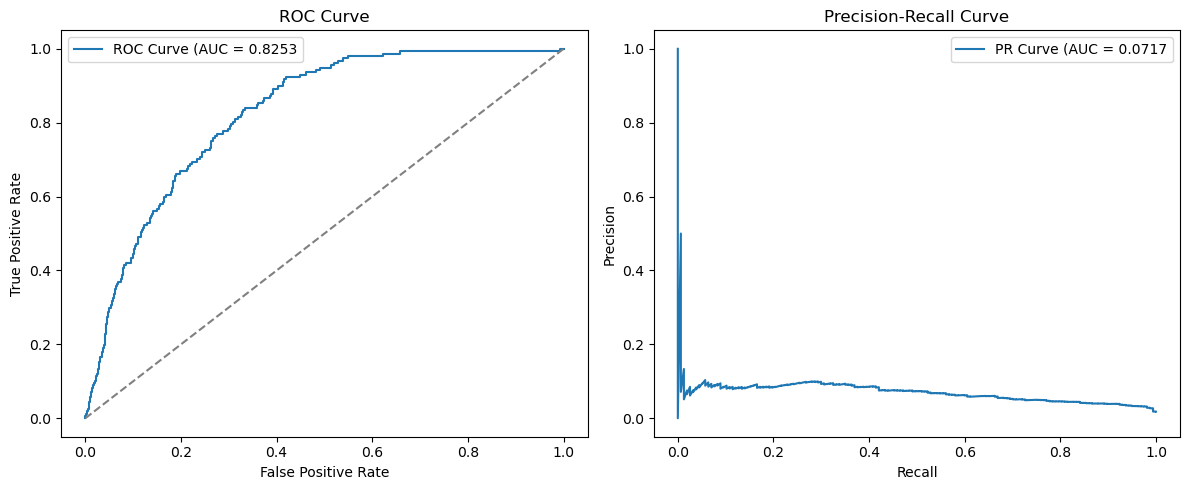

In [15]:
evaluate_model(model_smote, X_test_preprocessed, y_test)

## Undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

# Apply undersampling
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_preprocessed, y_train)

In [17]:
model_undersample = LogisticRegressionCV(max_iter=1000)
model_undersample.fit(X_train_resampled, y_train_resampled)
model_undersample.C_



array([0.00077426])

Test Accuracy: 0.7150
Confusion Matrix:
[[6082 2441]
 [  33  124]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      8523
           1       0.05      0.79      0.09       157

    accuracy                           0.71      8680
   macro avg       0.52      0.75      0.46      8680
weighted avg       0.98      0.71      0.82      8680

ROC AUC: 0.8318
PR AUC: 0.0701


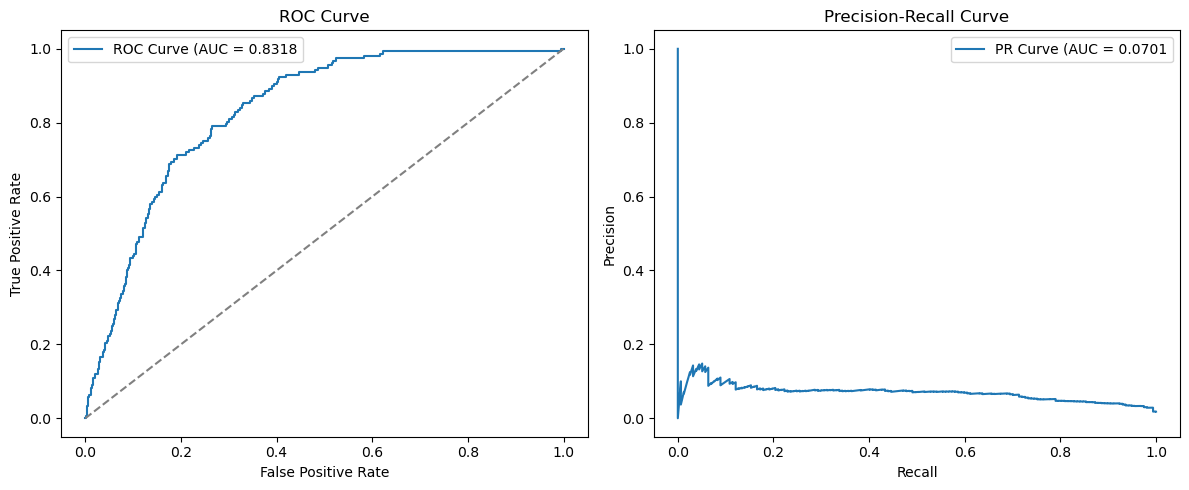

In [18]:
evaluate_model(model_undersample, X_test_preprocessed, y_test)

## Class-Weighted 

In [19]:
model_weighted = LogisticRegressionCV(max_iter=1000, class_weight='balanced')
model_weighted.fit(X_train_preprocessed, y_train)
model_weighted.C_


array([0.35938137])

Test Accuracy: 0.7306
Confusion Matrix:
[[6219 2304]
 [  34  123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      8523
           1       0.05      0.78      0.10       157

    accuracy                           0.73      8680
   macro avg       0.52      0.76      0.47      8680
weighted avg       0.98      0.73      0.83      8680

ROC AUC: 0.8338
PR AUC: 0.0731


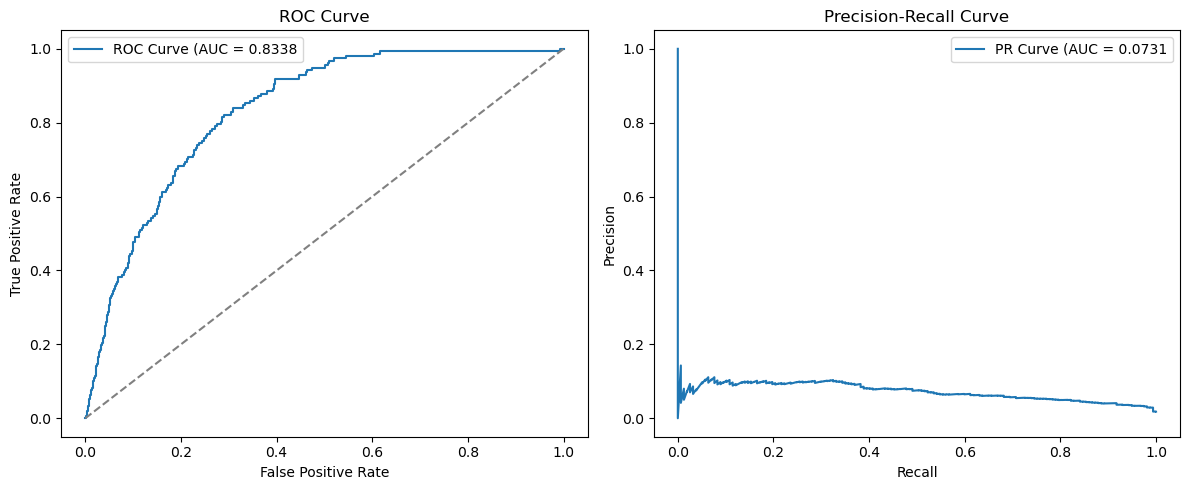

In [20]:
evaluate_model(model_weighted, X_test_preprocessed, y_test)

## Cost-Sensitive Learning

In [27]:
model_cs = LogisticRegressionCV(max_iter=1000, class_weight={0:1, 1:100})
model_cs.fit(X_train_preprocessed, y_train)
model_cs.C_


array([0.35938137])

Test Accuracy: 0.7306
Confusion Matrix:
[[6219 2304]
 [  34  123]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.73      0.84      8523
           1       0.05      0.78      0.10       157

    accuracy                           0.73      8680
   macro avg       0.52      0.76      0.47      8680
weighted avg       0.98      0.73      0.83      8680

ROC AUC: 0.8338
PR AUC: 0.0731


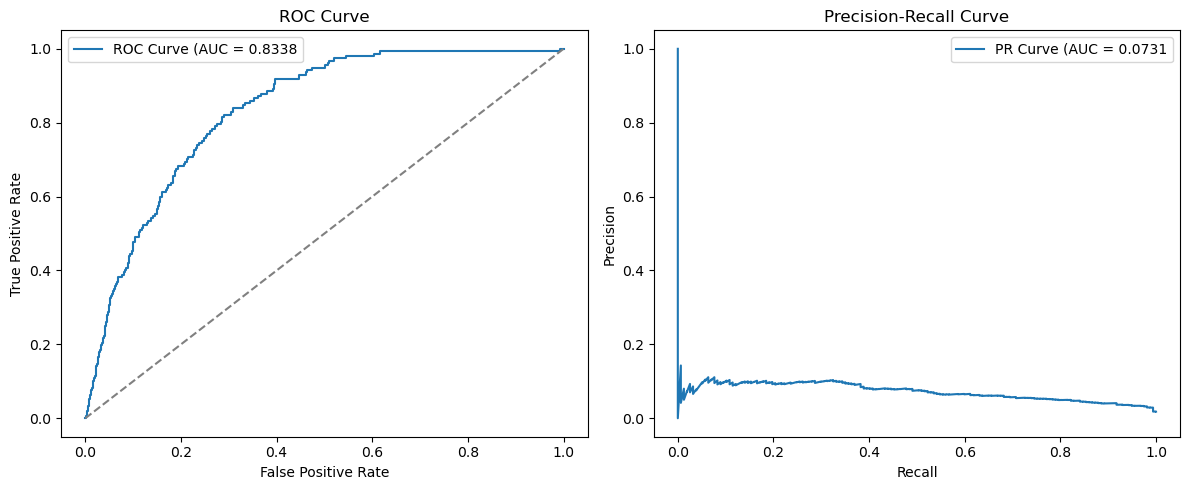

In [28]:
evaluate_model(model_weighted, X_test_preprocessed, y_test)

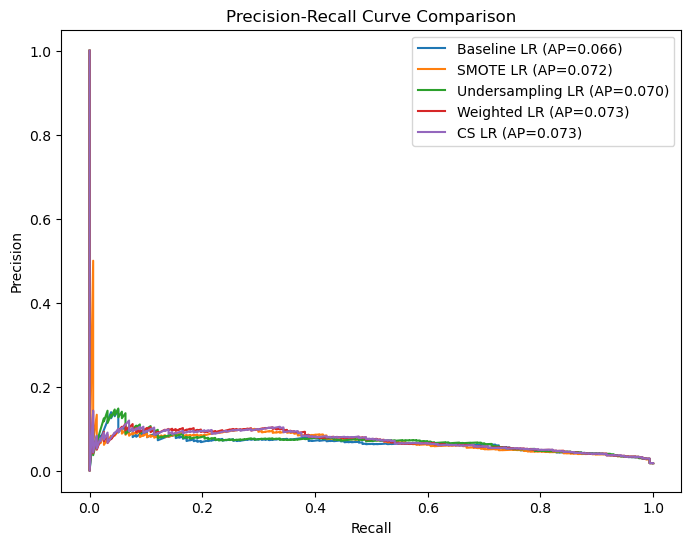

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

models = {
    "Baseline LR": model_base,
    "SMOTE LR": model_smote,
    "Undersampling LR": model_undersample,
    "Weighted LR": model_weighted,  # Use a model that supports class-weighting
    "CS LR": model_cs
}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_scores = model.predict_proba(X_test_preprocessed)[:, 1]  # Get positive class probabilities
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP={pr_auc:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()